LTWait values: [0.0, 793.6507936507936, 0.0, 793.6507936507936, 1587.3015873015872, 2380.952380952381, 3174.6031746031745, 3968.253968253968, 4761.904761904762, 5555.555555555556, 6349.206349206349, 7142.857142857142, 7936.507936507936, 8730.15873015873, 9523.809523809525, 10317.460317460318, 11111.111111111111, 11904.761904761905, 12698.412698412698, 13492.063492063493, 14285.714285714284, 15079.36507936508, 15873.015873015873, 16666.666666666668]
Second line values: [[545.685652669677, 623.5590967426484], [545.6854883524836, 623.5594506402265], [545.6855071441664, 623.5587424362013], [545.6854239043208, 623.5592691874471], [545.6854483261296, 623.5595013279723], [545.6852781009457, 623.5596979733443], [545.6854753588653, 623.5598746424633], [545.6854721896229, 623.5598893946444], [545.6854552032446, 623.5599138898435], [545.685452681703, 623.5594613094963], [545.6854414606728, 623.5592592314996], [545.6854029945941, 623.5597779779181], [545.6854683134837, 623.5601829299846], [545.685

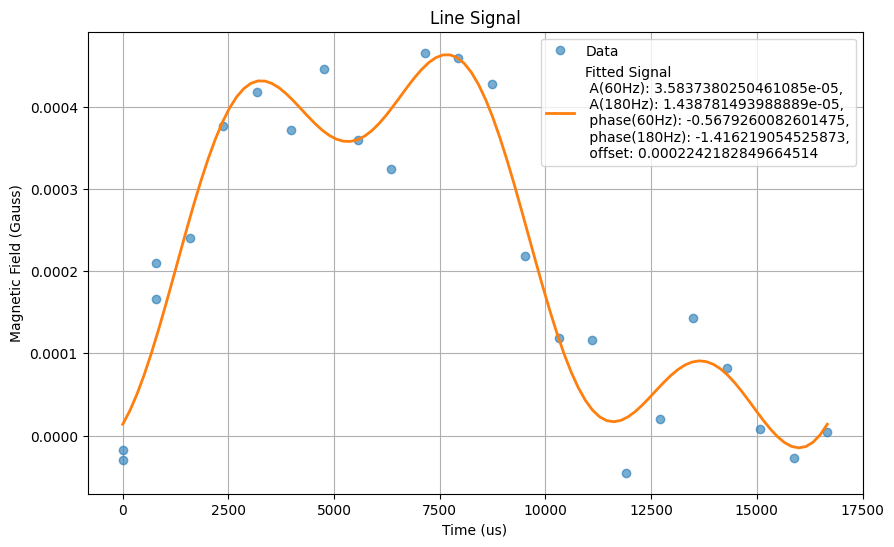

Optimized Parameters:
A_60: 3.5837380250461085e-05, phi1: -0.5679260082601475
A_180: 1.438781493988889e-05, phi2: -1.416219054525873
0.0002242182849664514


In [3]:
import os
import re
import numpy as np
# Directory containing the text files
data_dir = 'Z:\\Lab Data\\D52_Calibration_Ba137\\Fast_Ramsey_calibrations_180Hz_PhaseSweep\\properly_self_referenced_sweeps'  # Change this to the directory where your files are stored

# Lists to store extracted data
lt_wait_values = []
second_line_values = []
fourth_line_values = []
# Regular expression to match the file naming pattern
file_pattern = re.compile(r"ramsey_reference_transitions_LTWait(\d+\.\d+)us_Shots250_RamseyWait50us_20250312_.*")
# file_pattern = re.compile(r"ramsey_reference_transitions_LTWait(\d+\.\d+)us_Shots250_RamseyWait100us_20250120_.*")

# Loop through all files in the directory
for filename in os.listdir(data_dir):
    match = file_pattern.match(filename)
    if match:
        file_path = os.path.join(data_dir, filename)
        try:
            with open(file_path, 'r') as file:
                lines = file.readlines()
                # print(lines)
                # Extract the first line (LTWait value)
                lt_wait = float(lines[0].strip())
                lt_wait_values.append(lt_wait)

                # Extract the second line (two numbers)
                second_line = eval(lines[1].strip())  # Convert string to a Python list
                second_line_values.append(second_line)
                fourth_line = eval(lines[3].strip())
                fourth_line_values.append(fourth_line)
        except Exception as e:
            print(f"Error reading file {filename}: {e}")

# Print or save the extracted data
print("LTWait values:", lt_wait_values)
print("Second line values:", second_line_values)
print("fourth line values:", fourth_line_values)
# You can save these lists to a file if needed, e.g., using pickle or JSON


times = lt_wait_values
freqs = second_line_values
freqs_ref = fourth_line_values
freq_diffs = np.diff(freqs)
freq_ref_diff = np.diff(freqs_ref)

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the fitting function
def signal_model(t, A1 = 0.0003423806060810839, phi1 = 1.2893867862091697, A2 = 0.0005574657128318643, phi2 = -1.2192683736729186,offset = 0.00014702831939132153):
    f1 = 60  # Fixed frequency in Hz
    f2 = 180  # Fixed frequency in Hz
    return 2*np.pi*A1 * np.sin(2 * np.pi * f1 * t + phi1) + 2*np.pi*A2 * np.sin(2 * np.pi * f2 * t + phi2) + offset

t = np.array(times)
y_noisy = np.array((freq_ref_diff - freq_diffs)/(-3.498)).flatten()
# print(t,y)
# Fit the noisy data
initial_guess = [0.0001, 0.0, 0.0001, 0.0, 0]  # Initial guesses for [A1, phi1, A2, phi2]
params_opt, params_cov = curve_fit(signal_model, t, y_noisy, p0=initial_guess)

# Extract optimized parameters
A1_fit, phi1_fit, A2_fit, phi2_fit, o = params_opt

t_fit = np.linspace(min(t),max(t),100)
y_fit = signal_model(t_fit, A1_fit, phi1_fit, A2_fit, phi2_fit, o)

def line_signal(t, 
                A1=0.00037318157768892316, phi1=-0.8406971425701916,
                A2=-0.0004562778378973005, phi2=-4.804949550471232,
                offset=0.0006463292835800108):
    return (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * t + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * t + phi2) +
        offset
    ) - (
        2*np.pi*A1 * np.sin(2 * np.pi * 60 * 0 + phi1) +
        2*np.pi*A2 * np.sin(2 * np.pi * 180 * 0 + phi2) +
        offset
    )


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, y_noisy,'o', label="Data", alpha=0.6)
plt.plot(t_fit, y_fit,'-', label=f"Fitted Signal \n A(60Hz): {A1_fit},\n A(180Hz): {A2_fit},\n phase(60Hz): {phi1_fit},\n phase(180Hz): {phi2_fit},\n offset: {o}", linewidth=2)
# plt.plot(t_fit, line_signal(t_fit))
plt.legend()
plt.xlabel("Time (us)")
plt.ylabel("Magnetic Field (Gauss)")
plt.title("Line Signal")
plt.grid()
plt.show()

# Print the optimized parameters
print("Optimized Parameters:")
print(f"A_60: {A1_fit}, phi1: {phi1_fit}")
print(f"A_180: {A2_fit}, phi2: {phi2_fit}")
print(o)

In [119]:
%matplotlib widget